In [8]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import math
import torch
import torch.nn as nn
import random

from IPython.display import Image
from pathlib import Path
from diffusers.optimization import get_cosine_schedule_with_warmup
from tqdm import tqdm

from src.models.vae import VAE
from src.const import DATA_PATH, SEED
from src.preprocess import get_data_loader
from src.models.utils import pos_encoding

BATCH_SIZE = 32

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
vae = VAE(device)
train_dataloader = get_data_loader(DATA_PATH, BATCH_SIZE, vae)

for idx, batch in enumerate(train_dataloader):
    break

In [9]:
class EmbeddingBlock(nn.Module):
    """Embedding block for UNet."""

    def __init__(self, n_steps, d_model):
        super(EmbeddingBlock, self).__init__()
        self.n_steps = n_steps
        self.t_embed = self.init_pos_encoding(d_model)
        # self.l1 = nn.Linear(16, 32)
        # self.l2 = nn.Linear(32, d_model)
        # self.silu = nn.SiLU()

    def init_pos_encoding(self, d_model):
        t_embed = nn.Embedding(self.n_steps, d_model)
        t_embed.weight.data = pos_encoding(self.n_steps, d_model)
        t_embed.requires_grad = False
        return t_embed

    def forward(self, t):
        t = self.t_embed(t)
        # t = self.l1(t)
        # t = self.silu(t)
        # t = self.l2(t)
        return t

class ConvBlock(nn.Module):
    """Convolutional block for UNet."""

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same")
        self.relu = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bnorm(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bnorm(x)
        x = self.relu(x)
        return x

class DownsampleBlock(nn.Module):
    """Downsample block block for UNet."""

    def __init__(self, in_channels, out_channels):
        super(DownsampleBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv(x)
        pool = self.pool(x)
        return x, pool

class UpsampleBlock(nn.Module):
    """Upsample block for UNet."""

    def __init__(self, in_channels, out_channels):
        super(UpsampleBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = ConvBlock(2*out_channels, out_channels)

    def forward(self, x, down_tensor):
        x = self.upconv(x)
        x = torch.cat((x, down_tensor), dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    """UNet model for diffusion."""

    def __init__(self, batch_size, n_steps, input_size=32, in_channels=4, first_layer_channels=64):
        super(UNet, self).__init__()

        self.batch_size = batch_size

        # input size
        self.s1 = input_size
        self.s2 = self.s1 // 2
        self.s3 = self.s2 // 2

        # number of channels
        self.ch0 = in_channels
        self.ch1 = first_layer_channels
        self.ch2 = self.ch1 * 2
        self.ch3 = self.ch2 * 2

        # embedding blocks
        self.em1 = EmbeddingBlock(n_steps, in_channels * self.s1 * self.s1)
        self.em2 = EmbeddingBlock(n_steps, self.ch1 * self.s2 * self.s2)
        self.em3 = EmbeddingBlock(n_steps, self.ch2 * self.s3 * self.s3)
        self.em4 = EmbeddingBlock(n_steps, self.ch3 * self.s3 * self.s3)
        self.em5 = EmbeddingBlock(n_steps, self.ch2 * self.s2 * self.s2)

        # downsample blocks
        self.e1 = DownsampleBlock(self.ch0, self.ch1)
        self.e2 = DownsampleBlock(self.ch1, self.ch2)

        # upsample blocks
        self.d1 = UpsampleBlock(self.ch3, self.ch2)
        self.d2 = UpsampleBlock(self.ch2, self.ch1)

        # middle conv block
        self.middle = ConvBlock(self.ch2, self.ch3)

        # output layer
        self.out = nn.Conv2d(self.ch1, self.ch0, kernel_size=1, padding="same")

    def forward(self, x, t):
        t1 = self.em1(t).view(-1, self.ch0, self.s1, self.s1)
        t2 = self.em2(t).view(-1, self.ch1, self.s2, self.s2)
        t3 = self.em3(t).view(-1, self.ch2, self.s3, self.s3)
        t4 = self.em4(t).view(-1, self.ch3, self.s3, self.s3)
        t5 = self.em5(t).view(-1, self.ch2, self.s2, self.s2)

        x1, pool1 = self.e1(x + t1)
        x2, pool2 = self.e2(pool1 + t2)
        x = self.middle(pool2 + t3)
        x = self.d1(x + t4, x2)
        x = self.d2(x + t5, x1)
        x = self.out(x)
        return x

In [10]:
class DDPM(nn.Module):
    """DDPM model for diffusion."""

    def __init__(self, unet, device, min_beta=1e-4, max_beta=0.02):
        super(DDPM, self).__init__()
        self.unet = unet.to(device)
        self.device = device
        self.n_steps = unet.em1.n_steps
        self.betas = torch.linspace(min_beta, max_beta, self.n_steps).to(device) 
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[: i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x, t, eps=None):
        a = self.alpha_bars[t]
        if eps is None:
            eps = torch.randn(x.shape).to(self.device)
        x_with_noise = a.sqrt().reshape(-1, 1, 1, 1) * x + (1 - a).sqrt().reshape(-1, 1, 1, 1) * eps
        return x_with_noise
    
    def backward(self, x, t):
        return self.unet(x, t)

In [11]:
def training_loop(ddpm, loader, n_epochs, optim, device, model_name=None):
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    
    model_store_path = Path('model_checkpoints') / model_name if model_name is not None else None
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps
    n = len(loader.dataset)

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for _, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            optim.zero_grad()
            x = batch[0]
            eps = torch.randn_like(x).to(device)
            t = torch.randint(0, n_steps, (x.shape[0],)).to(device)
            x_with_noise = ddpm(x, t, eps)

            eps_theta = ddpm.backward(x_with_noise, t)
            loss = mse(eps_theta, eps)
            
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * x.shape[0] / n

        print(f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}")

        if model_store_path is not None and best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), model_store_path)
            print("Best model ever (stored)")

In [12]:
ddpm = DDPM(UNet(batch_size=BATCH_SIZE, n_steps=64), device).to(device)
ddpm.load_state_dict(torch.load("model_checkpoints/ddpm_model_t_without_linear_v1.pt"))
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-4)

In [13]:
training_loop(
    ddpm, 
    loader=train_dataloader, 
    n_epochs=100, 
    optim=optimizer, 
    device=device, 
    model_name="ddpm_model_t_without_linear.pt"
)

Epoch 1/100:  22%|██▏       | 7/32 [00:16<00:54,  2.18s/it]

In [163]:
def generate_new_images(ddpm, n_samples=1, input_size=32):
    """Generate new images using the trained DDPM model."""
    with torch.no_grad():
        device = ddpm.device
        x = torch.randn(n_samples, 4, input_size, input_size).to(device)
        x_0 = x.clone()

        for t in range(ddpm.n_steps)[::-1]:
            eps_theta = ddpm.backward(x, (torch.ones(n_samples, 1) * t).to(device).long())
            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eps_theta)

            if t > 0:
                z = torch.randn(n_samples, 4, input_size, input_size).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                sigma_t = beta_tilda_t.sqrt()
                
                x = x + sigma_t * z

    return x, x_0

def generate_gif(ddpm, gif_name, input_size=32, frames_per_gif=64):
    """Generate a GIF of the sampling process."""
    frames = []
    with torch.no_grad():
        device = ddpm.device
        x = torch.randn(1, 4, input_size, input_size).to(device)

        for t in range(ddpm.n_steps)[::-1]:
            eps_theta = ddpm.backward(x, (torch.ones(1, 1) * t).to(device).long())
            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eps_theta)

            if t > 0:
                z = torch.randn(1, 4, input_size, input_size).to(device)
                sigma_t = ddpm.betas[t].sqrt()
                x = x + sigma_t * z

            array = x.clone()
            array = vae.to_image(array)[0].cpu().numpy().transpose(1, 2, 0)
            min_vals = np.reshape(np.min(array, axis=(0, 1)), (1, 1, 3))
            max_vals = np.reshape(np.max(array, axis=(0, 1)), (1, 1, 3))
            scaled_array = (array - min_vals) / (max_vals - min_vals) * 255
            frames.append(scaled_array.astype(np.uint8))

    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])

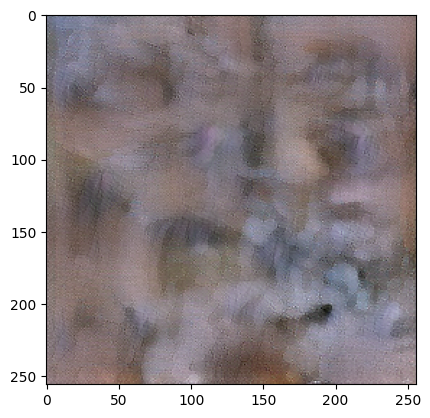

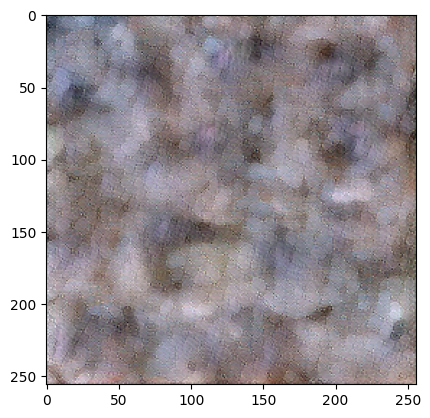

In [167]:
new, x_0 = generate_new_images(ddpm)
decoded = vae.to_image(new)
array = decoded[0].cpu().numpy()
# min max scaling
min_vals = np.reshape(np.min(array, axis=(1, 2)), (3, 1, 1))
max_vals = np.reshape(np.max(array, axis=(1, 2)), (3, 1, 1))
scaled_array = (array - min_vals) / (max_vals - min_vals)
plt.imshow(scaled_array.transpose(1, 2, 0))
plt.show()

decoded = vae.to_image(x_0)
array = decoded[0].cpu().numpy()
# min max scaling
min_vals = np.reshape(np.min(array, axis=(1, 2)), (3, 1, 1))
max_vals = np.reshape(np.max(array, axis=(1, 2)), (3, 1, 1))
scaled_array = (array - min_vals) / (max_vals - min_vals)
plt.imshow(scaled_array.transpose(1, 2, 0))
plt.show()

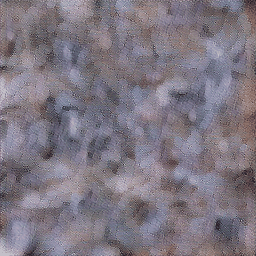

In [160]:
generate_gif(ddpm, "sampling.gif")
Image(open("sampling.gif", "rb").read())

In [ ]:
# from torchmetrics.image.fid import FrechetInceptionDistance

# fid = FrechetInceptionDistance(normalize=True)
# fid.update(real_images, real=True)
# fid.update(fake_images, real=False)

# print(f"FID: {float(fid.compute())}")

In [ ]:
# Improved DDPM

def get_beta_schedule(num_diffusion_timesteps):

    return betas_for_alpha_bar(
        num_diffusion_timesteps,
        lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
    )

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)